# Create RGB images

This notebook is an introduction to FITS image manipulation to create RGB images out of JWST images. Be careful when working with big images as they could make the kernel crash.

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch, make_lupton_rgb
from astropy.wcs import WCS
import dja_sepp

First, we select the images and bands we want to use for each color.

In [8]:
home = "/FlashStorage/DJA-SEpp"
field = "ceers-full-grizli-v7.2"
filters = {'b':'f150w', 'g':'f277w', 'r':'f444w'}

b_hdu = fits.open(glob.glob(f"{home}/fields/{field}/image/cutout/*{filters['b']}*sci_cutout.fits")[0], memmap=True)[0]
g_hdu = fits.open(glob.glob(f"{home}/fields/{field}/image/cutout/*{filters['g']}*sci_cutout.fits")[0], memmap=True)[0]
r_hdu = fits.open(glob.glob(f"{home}/fields/{field}/image/cutout/*{filters['r']}*sci_cutout.fits")[0], memmap=True)[0]

Then, since the long-wavelength channel of JWST/NIRCam has pixel twice as big as the ones from the short-wavelength channel, we down-sample the images from the short-wavelength channel (if any are used).

In [9]:
min_x = min(b_hdu.header["NAXIS1"], g_hdu.header["NAXIS1"], r_hdu.header["NAXIS1"])
if b_hdu.header["NAXIS1"] > min_x:
    print("B channel pixel scale is too high ! Down-sampling")
    b_image = b_hdu.data[::2,::2]
else: 
    b_image = b_hdu.data
    wcs = WCS(b_hdu.header)
if g_hdu.header["NAXIS1"] > min_x:
    print("G channel pixel scale is too high ! Down-sampling")
    g_image = g_hdu.data[::2,::2]
else: 
    g_image = g_hdu.data
    wcs = WCS(g_hdu.header)
if r_hdu.header["NAXIS1"] > min_x:
    print("R channel pixel scale is too high ! Down-sampling")
    r_image = r_hdu.data[::2,::2]
else: 
    r_image = r_hdu.data
    wcs = WCS(r_hdu.header)

Here we stack the images to create a full RGB image. We normalize each channel by its maximum value and multiply if by a constant (that can be tweaked) as a crude white-balance.

In [10]:
rgb = np.stack([0.2*r_image/np.max(r_image), 0.1*g_image/np.max(g_image), 1.4*b_image/np.max(b_image)], axis=-1)

Finally, we can display the full RGB image, with a legend showing which bands were used, and a scale bar to show the scale of the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


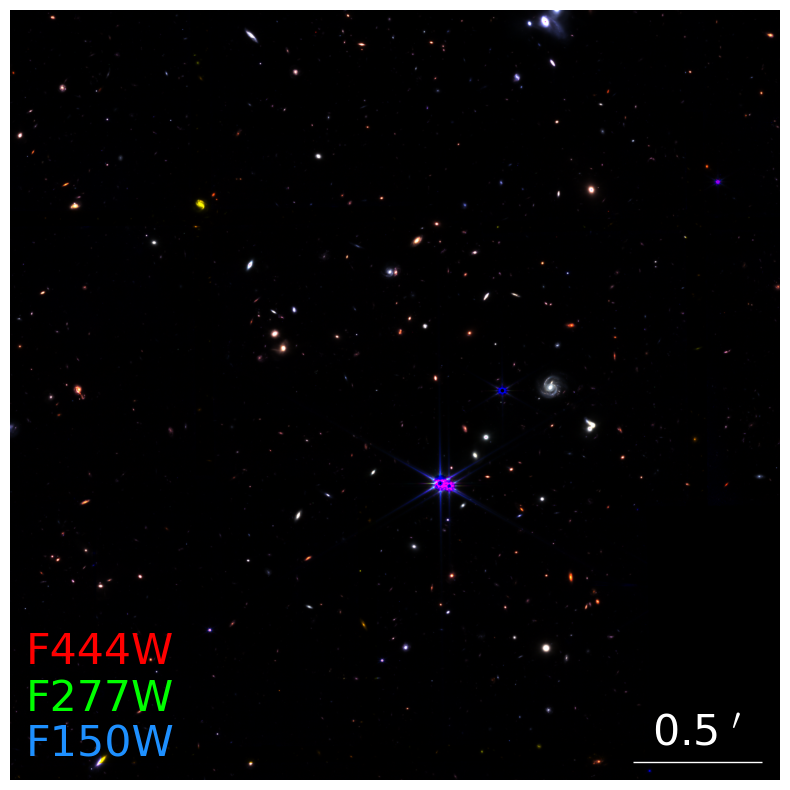

In [11]:
# %matplotlib ipympl
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection':wcs})
# norm = ImageNormalize(rgb, interval=ZScaleInterval())
norm = ImageNormalize(rgb, interval=MinMaxInterval(), stretch=LogStretch())
ax.imshow(255*rgb, origin='lower', norm=norm)
y1, y2 = ax.get_window_extent().get_points()[:,1]
fontsize = 0.05 * (y2-y1)
ax.text(0.02, 0.03, filters['b'].upper(), transform=ax.transAxes, color='dodgerblue', fontsize=fontsize)
ax.text(0.02, 0.09, filters['g'].upper(), transform=ax.transAxes, color='lime', fontsize=fontsize)
ax.text(0.02, 0.15, filters['r'].upper(), transform=ax.transAxes, color='red', fontsize=fontsize)
ax.set_axis_off()
dja_sepp.utils.add_good_scalebar(ax, wcs, fontsize=fontsize, pad=0.001*fontsize)
fig.tight_layout()
# fig.savefig(f"{home}/rgb_images/{field}_RGB.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()